In [14]:
import os
import sys
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.metrics import scores

ROOT_DIR = os.path.abspath("../../../")  # 指定根目录

# 导入Mask RCNN
sys.path.append(ROOT_DIR)  # 查找库的本地版本
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from samples.hpv_models.code.hpv import train, detect, NucleusDataset, NucleusConfig, NucleusInferenceConfig

In [15]:
ROOT_DIR = os.path.abspath("../../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
#from mrcnn import utils
from ap import compute_ap
from mrcnn import visualize
import mrcnn.model as modellib
import pickle

##############  配置参数  ####
LOGS_DIR = os.path.join(ROOT_DIR, "samples/hpv_models/logs")
DATASET_DIR = os.path.join(ROOT_DIR, "samples/hpv_models/data")   #  数据集
print(DATASET_DIR)
config = NucleusInferenceConfig()
DEVICE = "/cpu:0"
TEST_MODE = "inference"


#####  加载测试集数据  #####
dataset = NucleusDataset()
dataset.load_nucleus(DATASET_DIR, "stage1_test")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data
Images: 9
Classes: ['BG', 'yin', 'yin-yang', 'yang']


In [16]:
# Two helper functions
def get_ax(rows=1, cols=1, size=16):
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    fig.tight_layout()
    return ax
def text_save(filename, data):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename, 'a')
    for i in range(len(data)):
        s = str(data[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s = s.replace("'",'').replace(',','') +'\n'   #去除单引号，逗号，每行末尾追加换行符
        file.write(s)
    file.close()
    print("保存txt文件成功")

In [17]:
#####  导入模型  ####
# image_id = random.choice(dataset.image_ids)   # 随机选取一张测试集
image_ids = dataset.image_ids
print(image_ids)

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",model_dir=LOGS_DIR,config=config)
# weights_path = "/Mask_RCNN/logs/hpv20210105T1517/mask_rcnn_hpv_0799.h5"
weights_path = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/logs/mask_rcnn_model3-3_0150.h5"
model.load_weights(weights_path, by_name=True)



[0 1 2 3 4 5 6 7 8]


In [7]:

APs = []
count1 = 0
for image_id in image_ids:
    info = dataset.image_info[image_id]
    print("image_id: ", image_id)
    # ####重要步骤：获得测试图片的信息
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    #print(image)
    # ###保存实际结果
    if count1 == 0:
        # gt_image_id_all, gt_bbox_all, gt_class_id_all, gt_mask_all = [image_id]*len(gt_class_id), gt_bbox, gt_class_id, gt_mask
        gt_bbox_all, gt_class_id_all, gt_mask_all = gt_bbox, gt_class_id, gt_mask
    else:
        # gt_image_id_all=np.concatenate((gt_class_id_all, [image_id]*len(gt_class_id)), axis=0)
        gt_bbox_all = np.concatenate((gt_bbox_all, gt_bbox), axis=0)
        gt_class_id_all = np.concatenate((gt_class_id_all, gt_class_id), axis=0)
        gt_mask_all = np.concatenate((gt_mask_all, gt_mask), axis=2)
    # # 显示检测结果
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    r = results[0]
    # 保存预测结果
    if count1 == 0:
        # pre_image_id_all, pre_masks_all, pre_class_ids_all, pre_rois_all, pre_scores_all = [image_id]*len(r["class_ids"]),r['masks'], r["class_ids"], r["rois"], r["scores"]
        pre_masks_all, pre_class_ids_all, pre_rois_all, pre_scores_all = r['masks'], r["class_ids"], r["rois"], r["scores"]
    else:
        # pre_image_id_all = np.concatenate((pre_class_ids_all, [image_id]*len(r["class_ids"])), axis=0)
        pre_masks_all = np.concatenate((pre_masks_all, r['masks']), axis=2)
        pre_class_ids_all = np.concatenate((pre_class_ids_all, r['class_ids']), axis=0)
        pre_rois_all = np.concatenate((pre_rois_all, r['rois']), axis=0)
        pre_scores_all = np.concatenate((pre_scores_all, r['scores']), axis=0)

    count1 += 1
    #break

# ######绘制PR曲线######
AP, precisions, recalls, overlaps = compute_ap(gt_bbox_all, gt_class_id_all, gt_mask_all,
                                                    pre_rois_all, pre_class_ids_all, pre_scores_all, pre_masks_all)


image_id:  0
/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/stage1_test/1456/masksxxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   19.00000  max:  255.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32
image_id:  1
/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/stage1_test/1458/masksxxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   21.00000  max:  249.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   21.00000  max:  249.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.0

In [6]:
# print(pre_image_id_all)
# print(gt_image_id_all)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


precisions:  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.98214286
 0.98214286 0.98214286 0.98214286 0.96969697 0.96969697 0.96969697
 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697 0.96969697
 0.96969697 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213
 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213
 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213
 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213 0.96629213
 0.95555556 0.95192308 0.95192308 0.95192308 0

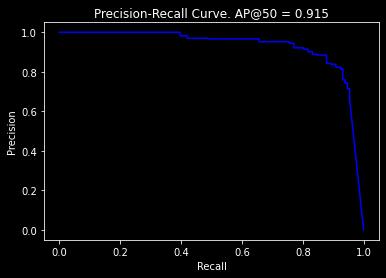

保存txt文件成功
保存txt文件成功


In [9]:
from ap import compute_ap, compute_matches
# # 在阈值0.5到0.95之间每隔0.1显示AP值
# utils.compute_ap_range(gt_bbox_all, gt_class_id_all, gt_mask_all, pre_rois_all, pre_class_ids_all, pre_scores_all, pre_masks_all, verbose=1)
## 在图片中显示真实与预测之间的差异
# visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'],
#                               dataset.class_names, ax=get_ax(), show_box=False, show_mask=False, iou_threshold=0.5, score_threshold=0.5)
# plt.show()


print("precisions: ", precisions)
print("AP: ", AP)

plt.figure("P-R Curve")
plt.title('Precision-Recall Curve. AP@50 = {:.3f}'.format(AP))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls, precisions, 'b', label='PR')
plt.show()
text_save('Kpreci.txt', precisions)
text_save('Krecall.txt', recalls)

In [18]:
from ap import compute_ap, compute_matches

#print(precisions)
def calculateMatch(image_id):
    info = dataset.image_info[image_id]
    print("image_id: ", image_id)
    # ####重要步骤：获得测试图片的信息
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    # # 显示检测结果
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    r = results[0]
    pre_masks, pre_class_ids, pre_rois, pre_scores = r['masks'], r["class_ids"], r["rois"], r["scores"]
    gt_match, pred_match, overlaps = compute_matches(gt_bbox, gt_class_id, gt_mask,
                                                     pre_rois, pre_class_ids, pre_scores, pre_masks)
    return (gt_match, pred_match, overlaps, pre_scores)

count1=0
for image_id in image_ids:
    gt_match, pred_match, overlaps, pre_scores = calculateMatch(image_id)
    # 保存预测结果
    if count1 == 0:
        gt_match_all,pred_match_all,pre_scores_all = gt_match, pred_match, pre_scores
    else:
        gt_match_all = np.concatenate((gt_match_all, gt_match), axis=0)
        pred_match_all = np.concatenate((pred_match_all, pred_match), axis=0)
        pre_scores_all = np.concatenate((pre_scores_all, pre_scores), axis=0)
    count1+=1

# sort pred_match_all by pre_scores_all
pred_match_all = np.array([x for _, x in sorted(zip(list(pre_scores_all),list(pred_match_all)),reverse=True)])

# Compute precision and recall at each prediction box step
precisions = np.cumsum(pred_match_all > -1) / (np.arange(len(pred_match_all)) + 1)
recalls = np.cumsum(pred_match_all > -1).astype(np.float32) / len(gt_match_all)

# Pad with start and end values to simplify the math
precisions = np.concatenate([[1], precisions, [0]])
recalls = np.concatenate([[0], recalls, [1]])

    


image_id:  0
/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/stage1_test/1456/masksxxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   19.00000  max:  255.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32
image_id:  1
/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/stage1_test/1458/masksxxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   21.00000  max:  249.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   21.00000  max:  249.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.0

precisions:  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.       

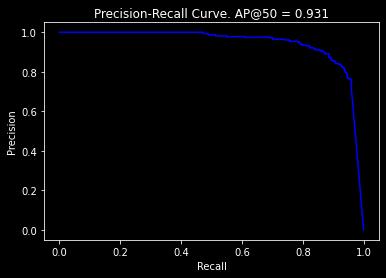

保存txt文件成功
保存txt文件成功


In [13]:
print("precisions: ", precisions)
print("AP: ", AP)

plt.figure("P-R Curve")
plt.title('Precision-Recall Curve. AP@50 = {:.3f}'.format(AP))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls, precisions, 'b', label='PR')
plt.show()
text_save('Kpreci.txt', precisions)
text_save('Krecall.txt', recalls)  